### Step 2 ML Risk Score Prediction Pipeline
**Author:** John Michael <br>
**Purpose:** The primary purpose of this notebook is to train the best ML model that can predict the patient's choice to undergo spinal surgery on a scale of 0 to 100 based on features such as demographics, ODI, ADI, and DOSPERT as well as inputs such as the percentage of complication and percentage of improvement.

In [12]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge, RidgeClassifier, Lasso
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor 
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import learning_curve
import shap
import copy
import pickle
sns.set_theme()
pd.set_option('display.max_rows', None)

In [13]:
data = pd.read_csv("../../data/data_processed/ml_data_w_risk_questions_processed_final.csv")
data.head()

,ohe__religion_10,cat__sex,cat__income,cat__education,cat__prior_surg,cat__succ_surg,num__age,num__odi_final,num__bmi,num__dospert_ethical,...,work_50improv_90para,work_90improv_1para,work_90improv_10para,work_90improv_50para,work_50improv_1death,work_50improv_10death,work_50improv_50death,work_90improv_1death,work_90improv_10death,work_90improv_50death
0,0.0,-1.015351,-0.559237,0.390836,0.604824,0.628025,-1.451225,-0.841732,-0.995194,0.634665,...,0,5,5,0,5,3,0,5,5,0
1,0.0,-1.015351,1.737435,0.390836,0.604824,0.628025,-1.298420,-0.705424,-0.731667,1.253831,...,0,5,3,2,4,2,1,5,3,1
2,1.0,0.911646,1.227063,0.390836,0.604824,0.628025,-1.705898,-0.978040,-1.087988,-0.397279,...,0,2,1,0,1,0,0,1,0,0
3,0.0,-1.015351,-0.048865,1.046883,0.604824,0.628025,-1.145616,-0.296500,0.634121,-0.603668,...,0,4,3,0,3,0,0,3,2,0
4,1.0,-1.015351,-0.559237,1.046883,0.604824,0.628025,-1.451225,-0.841732,-0.245044,0.015499,...,0,5,4,1,5,4,1,5,4,1


In [14]:
# Fix column names
cols = list(data.columns)
new_cols = [re.sub('^[A-z]{3}__', '', c) for c in cols]
data.columns = new_cols

# Drop spinal risk score
data.drop(columns=['spinal_risk_score'], inplace=True)
data.columns

Index(['religion_10', 'sex', 'income', 'education', 'prior_surg', 'succ_surg',
       'age', 'odi_final', 'bmi', 'dospert_ethical', 'dospert_financial',
       'dospert_health/safety', 'dospert_recreational', 'dospert_social',
       'height_m', 'weight_kg', 'ADI_NATRANK', 'ADI_STATERNK',
       'exer_50improv_1drop', 'exer_50improv_10drop', 'exer_50improv_50drop',
       'exer_50improv_90drop', 'exer_90improv_1drop', 'exer_90improv_10drop',
       'exer_90improv_50drop', 'exer_90improv_90drop', 'exer_50pain_1death',
       'exer_50pain_10death', 'exer_50pain_50death', 'exer_90pain_1death',
       'exer_90pain_10death', 'exer_90pain_50death', 'work_50improv_1drop',
       'work_50improv_10drop', 'work_50improv_50drop', 'work_50improv_90drop',
       'work_90improv_1drop', 'work_90improv_10drop', 'work_90improv_50drop',
       'work_50improv_1para', 'work_50improv_10para', 'work_50improv_50para',
       'work_50improv_90para', 'work_90improv_1para', 'work_90improv_10para',
       'work_

In [15]:
'''
Reshape the data from wide to long where each row represents one risk scenario.
'''
data_long = pd.melt(data,
                    id_vars=['religion_10', 'sex', 'income', 'education', 'prior_surg', 'succ_surg',
                             'age', 'odi_final', 'bmi', 'dospert_ethical', 'dospert_financial',
                             'dospert_health/safety', 'dospert_recreational', 'dospert_social',
                             'height_m', 'weight_kg', 'ADI_NATRANK', 'ADI_STATERNK'],
                    var_name='risk_question', value_name='choice')
split_df = data_long['risk_question'].str.split('_', expand=True)
data_long['activity'] = split_df[0]
data_long['pct_improv'] = split_df[1].str.extract(r'(\d{1,})', expand=False)
data_long['comp'] = split_df[2].str.extract(r'(drop|para|death)', expand=False)
data_long['pct_comp'] = split_df[2].str.extract(r'(\d{1,})', expand=False)
for c in ['pct_improv', 'pct_comp']:
    data_long[c] = pd.to_numeric(data_long[c])

In [16]:
ohe_cols = ['activity', 'comp']
num_cols = ['pct_improv', 'pct_comp']

In [17]:
# define preprocessing pipeline
ohe_pipe = Pipeline([
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

num_pipe = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', ohe_pipe, ohe_cols),
        ('num', num_pipe, num_cols)
    ])

to_process_df = data_long[ohe_cols + num_cols].copy()
to_process_df
preprocessor.fit(to_process_df)  # Fit the ColumnTransformer to your data
transformed_columns = preprocessor.get_feature_names_out(input_features=to_process_df.columns)

processed = preprocessor.transform(to_process_df)
processed_df = pd.DataFrame(processed, columns=transformed_columns)
cols = list(processed_df.columns)
new_cols = [re.sub('^[A-z]{3}__', '', c) for c in cols]
processed_df.columns = new_cols
drop_cols = ohe_cols + num_cols + ['risk_question']
data_long.drop(columns=drop_cols, inplace=True)
model_data = pd.concat([data_long, processed_df], axis=1)
model_data.head()

,religion_10,sex,income,education,prior_surg,succ_surg,age,odi_final,bmi,dospert_ethical,...,height_m,weight_kg,ADI_NATRANK,ADI_STATERNK,choice,activity_work,comp_drop,comp_para,pct_improv,pct_comp
0,0.0,-1.015351,-0.559237,0.390836,0.604824,0.628025,-1.451225,-0.841732,-0.995194,0.634665,...,-0.551831,-1.100657,-0.450913,-1.118697,4,0.0,1.0,0.0,-0.942809,-0.915608
1,0.0,-1.015351,1.737435,0.390836,0.604824,0.628025,-1.298420,-0.705424,-0.731667,1.253831,...,1.178208,-0.223692,0.320334,0.337078,4,0.0,1.0,0.0,-0.942809,-0.915608
2,1.0,0.911646,1.227063,0.390836,0.604824,0.628025,-1.705898,-0.978040,-1.087988,-0.397279,...,-1.046128,-1.335940,0.026525,-0.754753,3,0.0,1.0,0.0,-0.942809,-0.915608
3,0.0,-1.015351,-0.048865,1.046883,0.604824,0.628025,-1.145616,-0.296500,0.634121,-0.603668,...,0.683911,0.931335,-1.662873,-1.482640,3,0.0,1.0,0.0,-0.942809,-0.915608
4,1.0,-1.015351,-0.559237,1.046883,0.604824,0.628025,-1.451225,-0.841732,-0.245044,0.015499,...,1.425357,0.396601,-0.597818,-1.482640,5,0.0,1.0,0.0,-0.942809,-0.915608


In [18]:
# Saving processor pipeline to pickle object
with open('../../data/ml_models/choice_model_preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

In [19]:
X = model_data.drop(['choice'], axis=1)  # All columns except the last one are predictors
y = model_data['choice'].to_numpy()   # The last column is the response variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

In [23]:
# Define models
# classification or regression
MODEL_TYPE = 'regression'

if MODEL_TYPE == 'regression':
    models = {
        'Ridge': Ridge(),
        'Lasso': Lasso(),
        # 'Random Forest': RandomForestRegressor(),
        'XGBoost': XGBRegressor()
    }
else:
    models = {
        'Ridge': RidgeClassifier(),
        # 'Random Forest': RandomForestClassifier(),
        'XGBoost': XGBClassifier()
    }

# Define parameter grids for hyperparameter tuning
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    'XGBoost': {
        'n_estimators': np.arange(50, 200, 10),
        'learning_rate': np.linspace(0.005, 0.1, 25),
        'max_depth': np.arange(2, 12, 2),
        'subsample': np.linspace(0.5, 1, 6),
        'min_child_weight': np.arange(1, 10, 2),
        'gamma': np.linspace(0, 0.5, 5),
        'colsample_bytree': np.linspace(0.5, 1, 5)
    },
    'Ridge': {
        'alpha': [0, 1, 2]
    },
    'Lasso': {
        'alpha': [0, 1, 2]
    }
}
SEARCH_METHOD = 'random'
# neg_mean_squared_error or accuracy
if MODEL_TYPE == 'regression':
    SCORING_METHOD = 'neg_mean_squared_error'
else:
    SCORING_METHOD = 'accuracy'
degree = 1

# Perform hyperparameter tuning and model training
predictions = {}
train_predictions = {}
best_models = {}
best_params = {}
for model_name, model in models.items():
    if model_name in param_grids:
        if SEARCH_METHOD == 'grid':
            # Perform hyperparameter tuning
            grid_search = GridSearchCV(model, param_grids[model_name], cv=6, scoring=SCORING_METHOD)
            pipeline = Pipeline([
                ('poly', PolynomialFeatures(degree=degree)),
                ('grid_search', grid_search)
            ])
        else:
            # Perform hyperparameter tuning using RandomizedSearchCV
            randomized_search = RandomizedSearchCV(model, param_grids[model_name], n_iter=300, cv=10, n_jobs=-1,
                                                   scoring=SCORING_METHOD, random_state=42)
            pipeline = Pipeline([
                ('poly', PolynomialFeatures(degree=degree)),
                ('randomized_search', randomized_search)
            ])
    else:
        # No hyperparameter tuning for models without param grids
        pipeline = Pipeline([
            ('model', model)
        ])
    
    pipeline.fit(X_train, y_train)
    y_train_pred = pipeline.predict(X_train)

    # Accessing the best validation score
    if SEARCH_METHOD == 'grid':
        best_validation_score = grid_search.best_score_
        best_params[model_name] = grid_search.best_params_
    else:
        best_validation_score = randomized_search.best_score_
        best_params[model_name] = randomized_search.best_params_
    best_validation_mse = abs(best_validation_score)  # Convert to positive MSE
    
    print(f'{model_name} - Best Validation Score: {best_validation_mse}')
    
    y_pred = pipeline.predict(X_test)
    if SCORING_METHOD == 'neg_mean_squared_error':
        mse = mean_squared_error(y_test, y_pred)
        print(f'{model_name} - Test Mean Squared Error: {mse}')
    else:
        acc = accuracy_score(y_test, y_pred)
        print(f'{model_name} - Test Accuracy: {acc}')
    predictions[model_name] = y_pred
    train_predictions[model_name] = y_train_pred
    best_models[model_name] = pipeline

The total space of parameters 3 is smaller than n_iter=300. Running 3 iterations. For exhaustive searches, use GridSearchCV.


Ridge - Best Validation Score: 1.6006125227924453
Ridge - Test Mean Squared Error: 1.6017273321095797


The total space of parameters 3 is smaller than n_iter=300. Running 3 iterations. For exhaustive searches, use GridSearchCV.
/Users/johnmichael/opt/anaconda3/envs/vm_py38/lib/python3.8/site-packages/sklearn/base.py:1152: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/johnmichael/opt/anaconda3/envs/vm_py38/lib/python3.8/site-packages/sklearn/base.py:1152: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/johnmichael/opt/anaconda3/envs/vm_py38/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/johnmichael/opt/anaconda3/envs/vm_py38/lib/python3.8/site-packages/s

Lasso - Best Validation Score: 1.6006157814059587
Lasso - Test Mean Squared Error: 1.60173024895624


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


XGBoost - Best Validation Score: 0.5712074862816219
XGBoost - Test Mean Squared Error: 0.5412554622748831


In [46]:
final_model = XGBRegressor(**best_params['XGBoost'])
final_model.fit(X_train, y_train)
# Saving best model pipeline to pickle object
with open('../../data/ml_models/choice_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

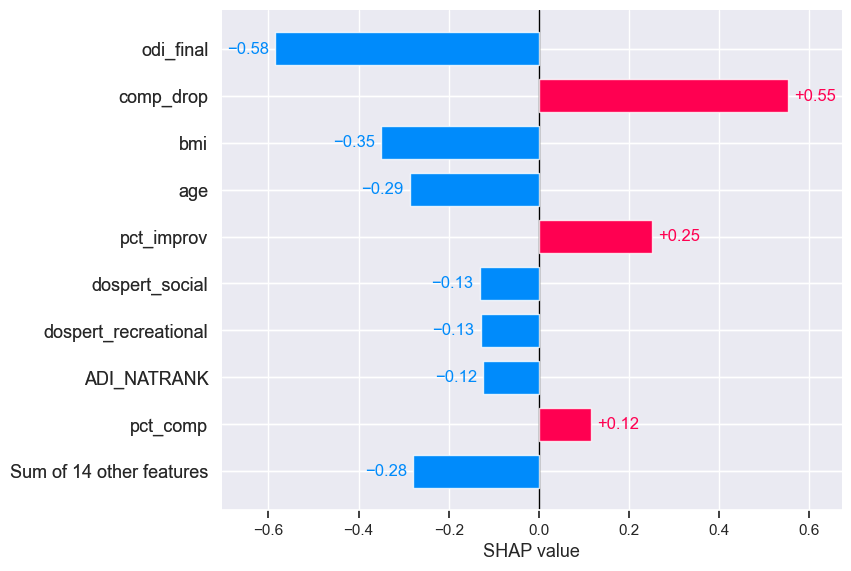

In [63]:
# Plot SHAP values
with open('../../data/ml_models/choice_model.pkl', 'rb') as f:
    choice_model = pickle.load(f)
shap.initjs()
explainer = shap.Explainer(choice_model.predict, X_train)

# Saving the SHAP explainer to pickle object
with open('../../data/ml_models/choice_model_shap.pkl', 'wb') as f:
    pickle.dump(explainer, f)

shap_values = explainer(X_test.sample(1))
shap.plots.bar(shap_values[0])

In [25]:
# Checking linear regression coefficients
ridge_model = make_pipeline(PolynomialFeatures(degree), Ridge(**best_params['Ridge']))
ridge_model.fit(X_train, y_train)
ridge_df = pd.DataFrame({'feature': ridge_model.named_steps['polynomialfeatures'].get_feature_names_out()})
ridge_df['coefficient'] = ridge_model.named_steps['ridge'].coef_
ridge_df.sort_values(by='coefficient', ascending=False)

,feature,coefficient
20,comp_drop,1.112869
22,pct_improv,0.287451
19,activity_work,0.199263
21,comp_para,0.145572
11,dospert_financial,0.122467
10,dospert_ethical,0.098587
9,bmi,0.093026
13,dospert_recreational,0.092234
6,succ_surg,0.043227
1,religion_10,0.030326


In [26]:
# Checking XGBoost predictions
test_df = X_test.copy()
test_df['y_test'] = y_test
test_df['y_pred_xgb'] = predictions['XGBoost']
test_df.sample(30)

,religion_10,sex,income,education,prior_surg,succ_surg,age,odi_final,bmi,dospert_ethical,...,weight_kg,ADI_NATRANK,ADI_STATERNK,activity_work,comp_drop,comp_para,pct_improv,pct_comp,y_test,y_pred_xgb
20556,1.0,-1.015351,-0.048865,1.046883,0.604824,0.628025,1.350184,-0.705424,-0.164418,-0.810056,...,0.032981,-0.193831,-0.390809,1.0,0.0,1.0,1.060660,-0.915608,4,3.660726
12722,0.0,-1.015351,-0.304051,-0.921257,0.604824,0.628025,1.248315,-0.432808,-0.762349,-0.190890,...,-0.352028,-0.744722,0.337078,1.0,1.0,0.0,-0.942809,-0.616274,1,0.824309
18811,0.0,0.911646,1.482249,1.702929,0.604824,0.628025,-0.534400,0.930273,0.272188,3.936884,...,-0.245081,0.871224,-0.026866,1.0,0.0,1.0,-0.942809,0.714096,4,1.860994
23995,1.0,-1.015351,-0.559237,-0.921257,0.604824,0.628025,-0.738139,-0.978040,0.883402,0.634665,...,1.038282,-1.515969,-0.754753,1.0,0.0,0.0,-0.942809,0.714096,0,-0.325411
15693,0.0,-1.015351,0.971878,0.390836,0.604824,0.628025,1.401119,1.339197,0.593522,-1.016445,...,0.503548,-0.046927,-0.754753,1.0,1.0,0.0,1.060660,-0.616274,0,1.573441
22436,1.0,-1.015351,1.227063,0.390836,0.604824,0.628025,-1.298420,1.884430,0.002903,-0.810056,...,-0.031187,-1.332338,0.337078,1.0,0.0,0.0,-0.942809,-0.915608,3,2.312674
13483,1.0,0.911646,-1.069608,0.390836,-1.653374,-1.592293,-1.502159,-0.978040,0.413851,-0.810056,...,-0.245081,-0.377461,-1.482640,1.0,1.0,0.0,-0.942809,0.714096,3,2.581596
12314,0.0,0.911646,1.227063,1.046883,-1.653374,-1.592293,-1.247486,-0.978040,-0.191666,-0.603668,...,-0.715648,1.091581,1.428909,1.0,1.0,0.0,-0.942809,-0.616274,2,2.830194
19816,0.0,-1.015351,-0.304051,-1.577303,0.604824,0.628025,1.401119,-0.432808,-0.116744,-1.016445,...,-0.031187,1.936280,1.792853,1.0,0.0,1.0,-0.942809,2.044466,0,-0.205645
20849,1.0,0.911646,-0.048865,0.390836,0.604824,0.628025,-0.890943,0.657657,-1.210490,-1.016445,...,-1.207604,0.357060,0.337078,1.0,0.0,1.0,1.060660,-0.616274,0,0.327694


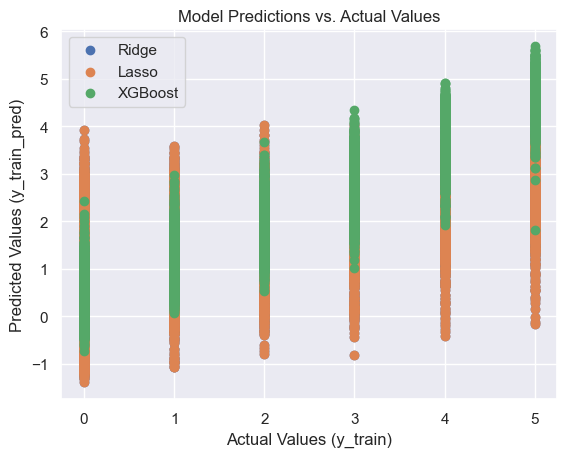

In [27]:
for model_name, y_train_pred in train_predictions.items():
    plt.scatter(y_train, y_train_pred, label=model_name)

plt.xlabel('Actual Values (y_train)')
plt.ylabel('Predicted Values (y_train_pred)')
plt.title('Model Predictions vs. Actual Values')
plt.legend()
plt.grid(True)
plt.show()

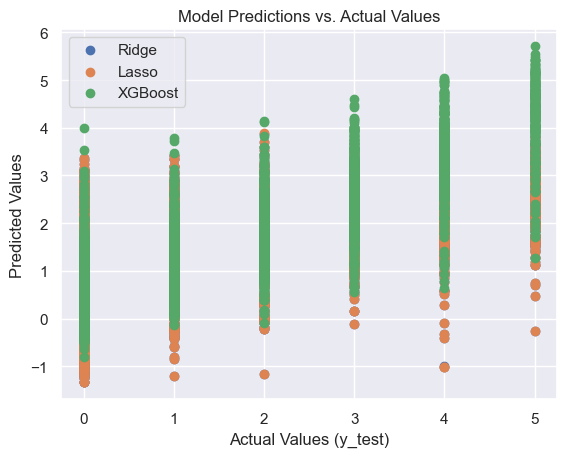

In [28]:
for model_name, y_pred in predictions.items():
    plt.scatter(y_test, y_pred, label=model_name)

plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values')
plt.title('Model Predictions vs. Actual Values')
plt.legend()
plt.grid(True)
plt.show()

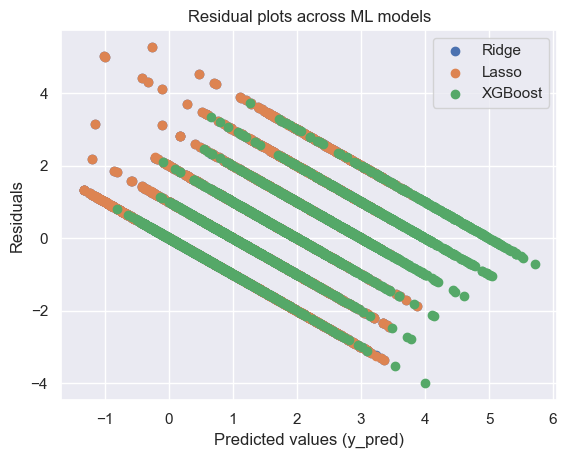

In [29]:
for model_name, y_pred in predictions.items():
    plt.scatter(y_pred, y_test - y_pred, label=model_name)

plt.xlabel('Predicted values (y_pred)')
plt.ylabel('Residuals')
plt.title('Residual plots across ML models')
plt.legend()
plt.grid(True)
plt.show()

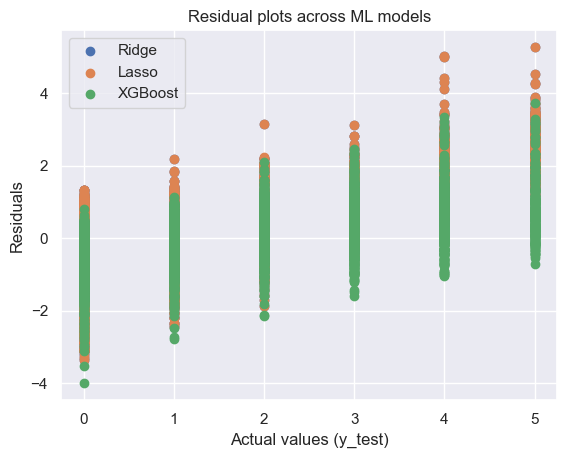

In [30]:
for model_name, y_pred in predictions.items():
    plt.scatter(y_test, y_test - y_pred, label=model_name)

plt.xlabel('Actual values (y_test)')
plt.ylabel('Residuals')
plt.title('Residual plots across ML models')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
def plot_learning_curves(model, X, y):
    train_sizes, train_scores, valid_scores = learning_curve(
        model, X, y, train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='neg_mean_squared_error', cv=5)
    
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = -np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training error', color='blue')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color='blue')
    plt.plot(train_sizes, valid_scores_mean, label='Validation error', color='orange')
    plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                     valid_scores_mean + valid_scores_std, alpha=0.1, color='orange')
    
    plt.xlabel('Training examples')
    plt.ylabel('Mean Squared Error')
    plt.title('Learning Curves')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


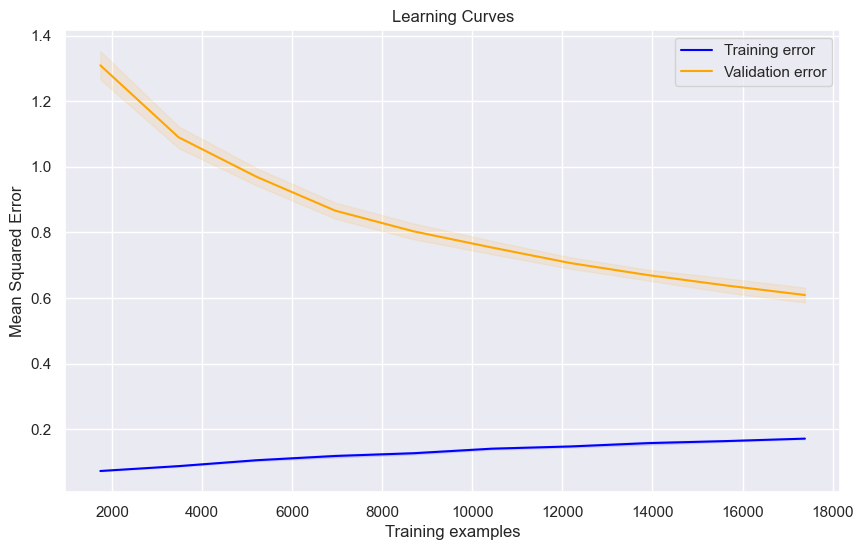

In [33]:
model = XGBRegressor(**best_params['XGBoost'])
plot_learning_curves(model, X_train, y_train)